In [18]:
import pandas as pd
import pyarrow.parquet as pq
from spark_hdfs import SparkHDFSConnector, SparkHDFSReader
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum
import seaborn as sns
from pyspark.sql.functions import concat, col, lit

23/10/09 11:34:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- FlightDate: timestamp_ntz (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: long (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- WeatherDelay: double (nullable = true)
 |-- NASDelay: double (nullable = true)
 |-- SecurityDel

+----+-----+-----------------+
|Year|Month|sum(WeatherDelay)|
+----+-----+-----------------+
|2019|    5|         617620.0|
|2019|    9|         264825.0|
|2021|   12|         505746.0|
|2019|    1|         516697.0|
|2018|   12|         370372.0|
|2023|    1|         565923.0|
|2018|    3|         262111.0|
|2022|   11|         341946.0|
|2021|    2|         536090.0|
|2020|    4|          26631.0|
|2022|   10|         222056.0|
|2020|   12|         216095.0|
|2020|   11|         101458.0|
|2023|    3|         446092.0|
|2022|    8|         653288.0|
|2023|    4|         490402.0|
|2021|    1|         250472.0|
|2020|    6|          97222.0|
|2022|    5|         455919.0|
|2020|    3|         111881.0|
+----+-----+-----------------+
only showing top 20 rows



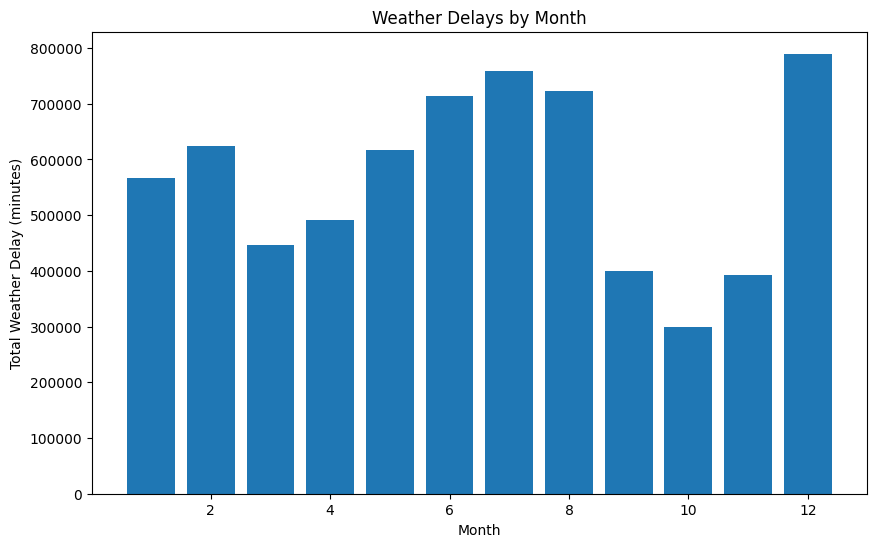

+-------------------+--------------------+----------+
|     OriginCityName|        DestCityName|TotalDelay|
+-------------------+--------------------+----------+
|        Chicago, IL|        New York, NY| 1196411.0|
|       New York, NY|         Chicago, IL| 1090046.0|
|       New York, NY|          Boston, MA|  799267.0|
|          Miami, FL|        New York, NY|  750592.0|
|        Orlando, FL|        New York, NY|  741012.0|
|         Boston, MA|        New York, NY|  710817.0|
|Fort Lauderdale, FL|        New York, NY|  710569.0|
|       New York, NY| Fort Lauderdale, FL|  702121.0|
|        Atlanta, GA|        New York, NY|  685516.0|
|       New York, NY|         Atlanta, GA|  662213.0|
|       New York, NY|         Orlando, FL|  651108.0|
|        Orlando, FL|          Newark, NJ|  646709.0|
|       New York, NY|           Miami, FL|  604145.0|
|    Los Angeles, CA|   San Francisco, CA|  593504.0|
|     Washington, DC|        New York, NY|  579588.0|
|        Houston, TX|Dallas/

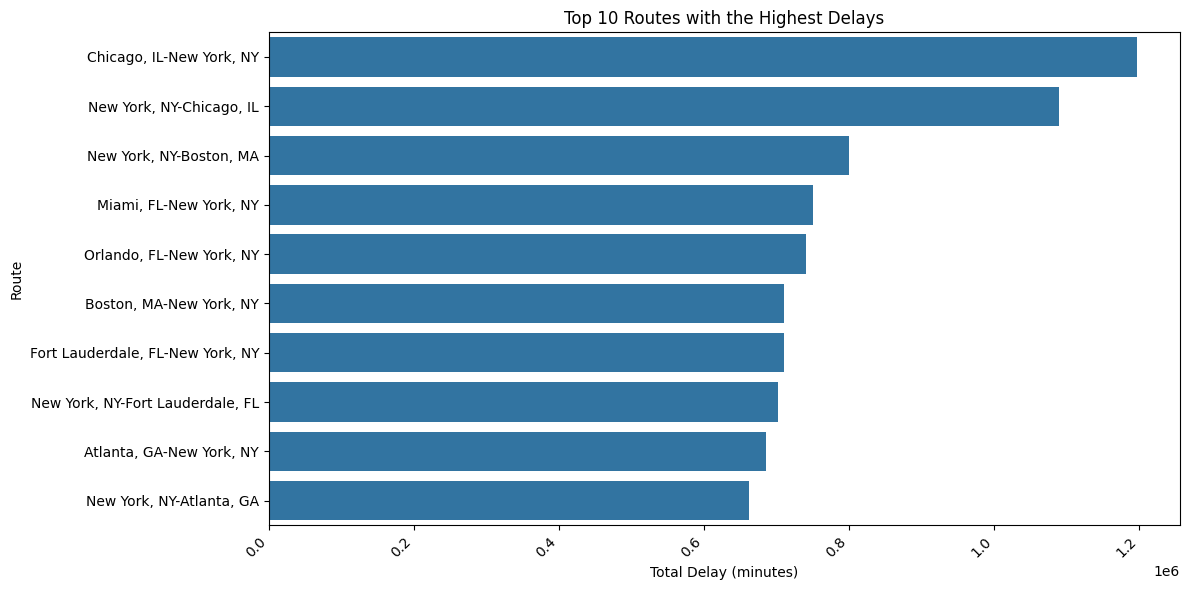

In [19]:
if __name__ == "__main__":
    hdfs_url = "http://localhost:9870"
    hdfs_user = "anna"
    spark_app_name = "MySparkApp"
    spark_master_url = "local[2]"  # Use Spark cluster's master URL if not running locally

    # Create an instance of the SparkHDFSConnector class
    connector = SparkHDFSConnector(hdfs_url, hdfs_user, spark_app_name, spark_master_url)

    # Define the Parquet file path
    parquet_file_path = "hdfs://localhost:9000/user/anna/flight_data/features_added.parquet"

    # Read and show the Parquet file using the connector
    df = connector.read_parquet_from_hdfs(parquet_file_path)

    # Stop the Spark session for the connector
    connector.stop_spark_session()

    # Create an instance of the SparkHDFSReader class
    hdfs_reader = SparkHDFSReader(hdfs_url, hdfs_user)

    # Create a Spark session for other operations
    hdfs_reader.create_spark_session(app_name="MySparkApp2")

    # Read and print the schema for the Parquet file using the reader
    df = hdfs_reader.read_parquet_file(parquet_file_path)

    #hdfs_reader.show_dataframe(df)
    hdfs_reader.print_schema(df)

    # Load the Parquet data
    parquet_data = hdfs_reader.read_parquet_file(parquet_file_path)

    # Handle missing values
    parquet_data = parquet_data.dropna(subset=["DepDelay", "CarrierDelay", "WeatherDelay", "SecurityDelay"])

    # Calculate Total Delay
    parquet_data = parquet_data.withColumn("TotalDelay", col("CarrierDelay") + col("WeatherDelay") + col("SecurityDelay"))

    # Analyze Delay Cause
    weather_delays_by_month = parquet_data.groupBy("Year", "Month").agg({"WeatherDelay": "sum"})
    weather_delays_by_month.show()

    # Data Visualization : Plot weather delays by month
    weather_delays = weather_delays_by_month.toPandas()
    plt.figure(figsize=(10, 6))
    plt.bar(weather_delays["Month"], weather_delays["sum(WeatherDelay)"])
    plt.xlabel("Month")
    plt.ylabel("Total Weather Delay (minutes)")
    plt.title("Weather Delays by Month")
    plt.show()

    # Top Routes With Highest Delay 
    columns_of_interest = ["OriginCityName", "DestCityName", "DepDelay"]
    routes_data = parquet_data.select(columns_of_interest)

    delay_per_route = routes_data.groupBy("OriginCityName", "DestCityName") \
                            .agg(sum("DepDelay").alias("TotalDelay"))
    
    top_delayed_routes = delay_per_route.orderBy("TotalDelay", ascending=False)

    # Display the top delayed routes
    top_delayed_routes.show()

    # Create a new column that concatenates OriginCityName and DestCityName
    top_delayed_routes = top_delayed_routes.withColumn(
        "Route",
        concat(col("OriginCityName"), lit("-"), col("DestCityName"))
    )

    # Convert the DataFrame to Pandas for visualization
    top_delayed_routes_pd = top_delayed_routes.toPandas()

    # Create a bar chart to visualize the top delayed routes
    plt.figure(figsize=(12, 6))
    sns.barplot(x="TotalDelay", y="Route", data=top_delayed_routes_pd.head(10))
    plt.xlabel("Total Delay (minutes)")
    plt.ylabel("Route")
    plt.title("Top 10 Routes with the Highest Delays")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Show the chart
    plt.show()

    # Close the Spark session for other operations
    hdfs_reader.close_spark_session()